In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# better display of review text in dataframes
pd.set_option('display.max_colwidth', None) 

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

# Auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

from tensorflow import keras

In [87]:
# This cell is only here as a bug fix when running RNN on my GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Load data

## Load dataset

In [55]:
import pickle

PICKLE_PATH = "allocine_dataset/data/allocine_dataset.pickle"

with open(PICKLE_PATH, 'rb') as reader:
    data = pickle.load(reader)

# Reviews need to be tokenized
train_reviews = np.array(data["train_set"]['review'])
val_reviews = np.array(data["val_set"]['review'])
test_reviews = np.array(data["test_set"]['review'])

# Used to train fit tokenizer
#all_reviews = np.concatenate((train_reviews, val_reviews, test_reviews), axis=0)

y_train = np.array(data["train_set"]['polarity'])
y_val = np.array(data["val_set"]['polarity'])
y_test = np.array(data["test_set"]['polarity'])
class_names = data['class_names']

## Tokenize

We train the tokenizer on the reviews of the train set

In [56]:
MAX_NB_WORDS = 20000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=MAX_NB_WORDS,
    oov_token="<unk>",
)
tokenizer.fit_on_texts(train_reviews)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

Found 186308 unique tokens.


In [57]:
train_reviews_tokenized = tokenizer.texts_to_sequences(train_reviews)
val_reviews_tokenized = tokenizer.texts_to_sequences(val_reviews)
test_reviews_tokenized = tokenizer.texts_to_sequences(test_reviews)

In [58]:
some_review = train_reviews_tokenized[0]
some_review[:15]

[45, 68, 4664, 17, 77, 15081, 7, 80, 9, 8746, 2505, 249, 439, 17, 1181]

In [59]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in some_review[:15]])

"si vous cherchez du cinéma abrutissant à tous les étages n'ayant aucune peur du cliché"

Average length: 91.5
Max length: 389


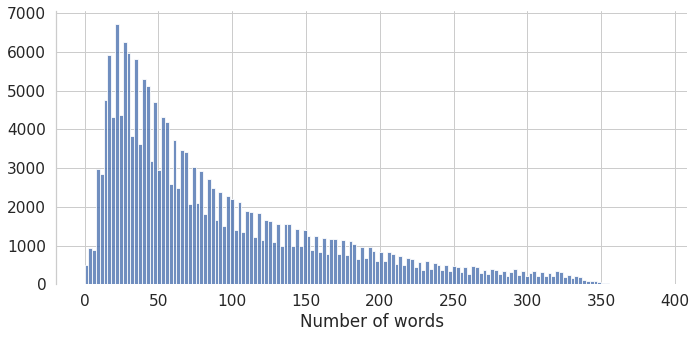

In [60]:
reviews_len = [len(s) for s in train_reviews_tokenized+val_reviews_tokenized+test_reviews_tokenized]
print("Average length: {:.1f}".format(np.mean(reviews_len)))
print("Max length: {}".format(max(reviews_len)))

plt.figure(figsize=(10,5))
ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Number of words')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/word-vectors/number_of_words.png', dpi=200)

In [91]:
assert(reviews_len.count(0) == 0)
# Important not to have empty tensors: https://github.com/tensorflow/tensorflow/issues/33148

Call this if the assert failed

In [90]:
print('Removing {} empty sequences'.format(reviews_len.count(0)))

train_reviews_not_empty = []
y_train_not_empty = []
for seq, label in zip(train_reviews_tokenized, y_train):
    if len(seq) > 0:
        train_reviews_not_empty.append(seq)
        y_train_not_empty.append(label)
    
val_reviews_not_empty = []
y_val_not_empty = []
for seq, label in zip(val_reviews_tokenized, y_val):
    if len(seq) > 0:
        val_reviews_not_empty.append(seq)
        y_val_not_empty.append(label)

test_reviews_not_empty = []
y_test_not_empty = []
for seq, label in zip(test_reviews_tokenized, y_test):
    if len(seq) > 0:
        test_reviews_not_empty.append(seq)
        y_test_not_empty.append(label)
        
train_reviews_tokenized = train_reviews_not_empty
y_train = np.array(y_train_not_empty)
val_reviews_tokenized = val_reviews_not_empty
y_val = np.array(y_val_not_empty)
test_reviews_tokenized = test_reviews_not_empty
y_test = np.array(y_test_not_empty)

# Test
reviews_len = [len(s) for s in train_reviews_tokenized+val_reviews_tokenized+test_reviews_tokenized]
assert(reviews_len.count(0) == 0)

Removing 8 empty sequences


## Padding

Then we pad short sequences with 0s until they reach a fixed length. Long sequences are also truncated.

In [92]:
MAX_LENGTH_SEQ = 350 #

X_train = tf.keras.preprocessing.sequence.pad_sequences(
    train_reviews_tokenized, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_val = tf.keras.preprocessing.sequence.pad_sequences(
    val_reviews_tokenized, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_reviews_tokenized, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

print('Shape of X_train tensor:', X_train.shape)
print('Shape of X_val tensor:', X_val.shape)
print('Shape of X_test tensor:', X_test.shape)

Shape of X_train tensor: (159993, 350)
Shape of X_val tensor: (19999, 350)
Shape of X_test tensor: (20000, 350)


# Averaging embeddings

## Model

First we train an model which classify reviews based on the average vector of their embeddings.

In [63]:
from tensorflow import keras
from tensorflow.keras import layers

max_features = MAX_NB_WORDS
embedding_dim = 128

model = keras.models.Sequential(name='average_embeddings')
model.add(layers.Embedding(max_features, embedding_dim,
                           input_shape=[None]),)
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [64]:
initial_weights = model.get_weights()
model.summary()

Model: "average_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
global_average_pooling1d_6 ( (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,560,129
Trainable params: 2,560,129
Non-trainable params: 0
_________________________________________________________________


## Training

In [44]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=128, verbose=1)

Train on 159993 samples, validate on 19999 samples
Epoch 1/10
159993/159993 [==============================] - 30s 185us/sample - loss: 0.4688 - accuracy: 0.8193 - val_loss: 0.2994 - val_accuracy: 0.9023
Epoch 2/10
159993/159993 [==============================] - 28s 174us/sample - loss: 0.2548 - accuracy: 0.9124 - val_loss: 0.2281 - val_accuracy: 0.9211
Epoch 3/10
159993/159993 [==============================] - 29s 181us/sample - loss: 0.2058 - accuracy: 0.9265 - val_loss: 0.2105 - val_accuracy: 0.9241
Epoch 4/10
159993/159993 [==============================] - 29s 184us/sample - loss: 0.1833 - accuracy: 0.9335 - val_loss: 0.2021 - val_accuracy: 0.9279
Epoch 5/10
159993/159993 [==============================] - 27s 171us/sample - loss: 0.1698 - accuracy: 0.9376 - val_loss: 0.2009 - val_accuracy: 0.9284
Epoch 6/10
159993/159993 [==============================] - 28s 175us/sample - loss: 0.1601 - accuracy: 0.9414 - val_loss: 0.2019 - val_accuracy: 0.9282
Epoch 7/10
159993/159993 [=====

In [45]:
_, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(accuracy)

0.92519623


This simple technique works surprisingly well on our task !

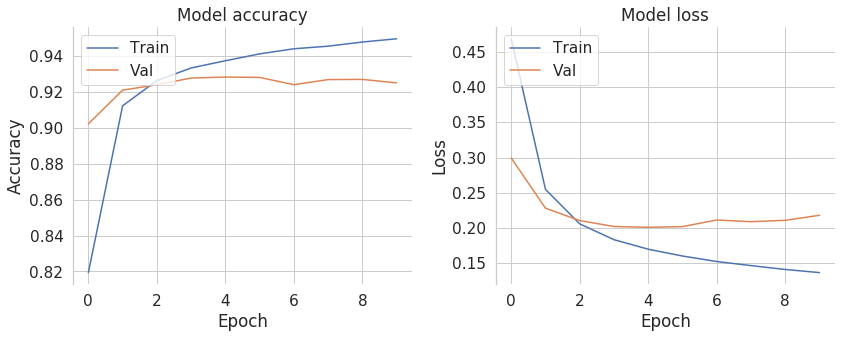

In [50]:
from utils import plot_training_curves

fig = plot_training_curves(history)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/average_embedding_training.png', dpi=200)

## Accuracy vs Training data

In [80]:
from sklearn import metrics 
from utils import accuracy_vs_train_size

TRAINING_SIZES = [1000, 5000, 10000, 20000, 40000, 80000, 120000, 160000]

test_accuracies = accuracy_vs_train_size(
    model, initial_weights, X_train, y_train, 
    X_val, y_val, X_test, y_test, TRAINING_SIZES
)
#TODO: pickle export

Train on 1000 samples, validate on 20000 samples
Epoch 1/20
1000/1000 - 2s - loss: 0.6927 - accuracy: 0.5160 - val_loss: 0.6924 - val_accuracy: 0.5162
Epoch 2/20
1000/1000 - 2s - loss: 0.6919 - accuracy: 0.5230 - val_loss: 0.6918 - val_accuracy: 0.5155
Epoch 3/20
1000/1000 - 1s - loss: 0.6908 - accuracy: 0.5250


KeyboardInterrupt: 

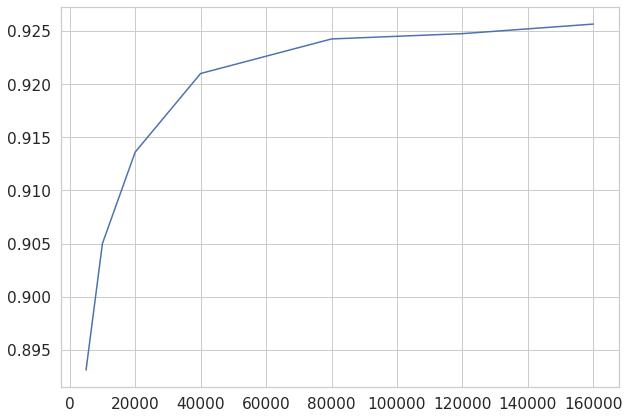

In [81]:
fig = plt.figure(figsize=(10,7))
plt.plot(sizes, test_accuracies)

In [70]:
history.history

{'loss': [0.39505905687510967, 0.2010172151889652, 0.17322159384340047],
 'accuracy': [0.8495875, 0.92640626, 0.9359],
 'val_loss': [0.22675582159161567, 0.2027736497581005, 0.20940217421352864],
 'val_accuracy': [0.92165, 0.92595, 0.9229]}

# Recurrent Neural Networks

## Model

In [98]:
from tensorflow import keras
from tensorflow.keras import layers

embedding_dim = 256
dropout_rate = 0.25

model = keras.models.Sequential(name='rnn')
model.add(layers.Embedding(MAX_NB_WORDS, embedding_dim,
                           mask_zero=True,                           
                           input_shape=[None]),)

model.add(layers.GRU(512, dropout=dropout_rate))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [99]:
initial_weights = model.get_weights()
model.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 256)         5120000   
_________________________________________________________________
gru_2 (GRU)                  (None, 512)               1182720   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 6,303,233
Trainable params: 6,303,233
Non-trainable params: 0
_________________________________________________________________


## Training

In [82]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5, batch_size=32, verbose=1) # val_accuracy: 0.9513 after 2 epoches !

Train on 179975 samples, validate on 10011 samples
Epoch 1/5
179975/179975 [==============================] - 298s 2ms/sample - loss: 0.1942 - accuracy: 0.9218 - val_loss: 0.1309 - val_accuracy: 0.9496
Epoch 2/5
179975/179975 [==============================] - 294s 2ms/sample - loss: 0.1095 - accuracy: 0.9594 - val_loss: 0.1306 - val_accuracy: 0.9513
Epoch 3/5
  5824/179975 [..............................] - ETA: 4:38 - loss: 0.0590 - accuracy: 0.9795

KeyboardInterrupt: 

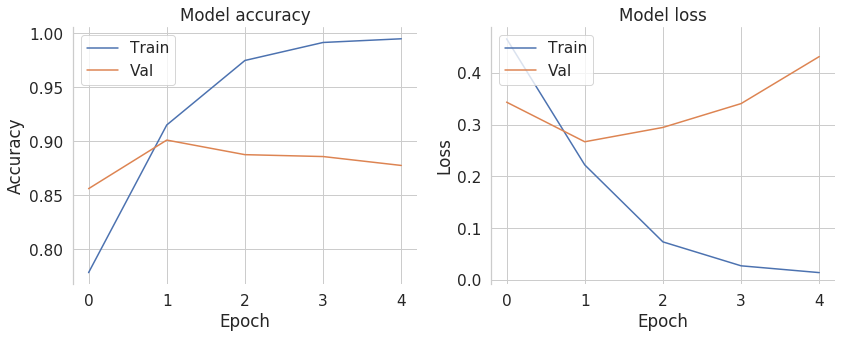

In [21]:
fig = plot_training_curves(history)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/rnn_training.png', dpi=200)

RNN seems to overfit very quickly, but the validation accuracy of the very firsts epoches is quite good !

## Accuracy vs Training data

In [100]:
from sklearn import metrics 
from utils import accuracy_vs_train_size

TRAINING_SIZES = [1000, 5000, 10000, 20000, 40000, 80000, 120000, 160000]

test_accuracies = accuracy_vs_train_size(
    model, initial_weights, X_train, y_train, 
    X_val, y_val, X_test, y_test, TRAINING_SIZES
)
#TODO: pickle export

Train on 1000 samples, validate on 19999 samples
Epoch 1/30
1000/1000 - 4s - loss: 0.6780 - accuracy: 0.5530


KeyboardInterrupt: 

# Convolutional Neural Networks

Here we implement [this model](https://arxiv.org/abs/1412.1058), because it has a pretty good accuracy on the english IMDB sentiment analysis dataset.

## Model

In [22]:
emb_dim = 512
hid_dim = 512
sentence_length = MAX_LENGTH_SEQ
num_words = MAX_NB_WORDS
dropout_rate = 0.05
    
input_layer = tf.keras.layers.Input(shape=(sentence_length,), dtype=tf.int32)

layer = tf.keras.layers.Embedding(num_words, output_dim=emb_dim)(input_layer)

layer_conv3 = tf.keras.layers.Conv1D(hid_dim, 3, activation="relu")(layer)
layer_conv3 = tf.keras.layers.GlobalMaxPooling1D()(layer_conv3)

layer_conv4 = tf.keras.layers.Conv1D(hid_dim, 2, activation="relu")(layer)
layer_conv4 = tf.keras.layers.GlobalMaxPooling1D()(layer_conv4)

layer = tf.keras.layers.concatenate([layer_conv4, layer_conv3], axis=1)
layer = tf.keras.layers.BatchNormalization()(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)

output = tf.keras.layers.Dense(1, activation="sigmoid")(layer)

model = tf.keras.models.Model(name='cnn', inputs=[input_layer], outputs=output)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [23]:
model.summary()

Model: "cnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 364)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 364, 512)     10240000    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 363, 512)     524800      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 362, 512)     786944      embedding_2[0][0]                
________________________________________________________________________________________________

## Training

In [24]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/cnn_weights.hdf5',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5, batch_size=32, 
    callbacks=[checkpointer], verbose=1)

Train on 12000 samples, validate on 4000 samples
Epoch 1/5
11968/12000 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.8500
Epoch 00001: val_loss improved from inf to 0.31311, saving model to /tmp/cnn_weights.hdf5
12000/12000 [==============================] - 29s 2ms/sample - loss: 0.3416 - accuracy: 0.8501 - val_loss: 0.3131 - val_accuracy: 0.8825
Epoch 2/5
11968/12000 [============================>.] - ETA: 0s - loss: 0.0655 - accuracy: 0.9766
Epoch 00002: val_loss improved from 0.31311 to 0.25273, saving model to /tmp/cnn_weights.hdf5
12000/12000 [==============================] - 29s 2ms/sample - loss: 0.0658 - accuracy: 0.9763 - val_loss: 0.2527 - val_accuracy: 0.9050
Epoch 3/5
11968/12000 [============================>.] - ETA: 0s - loss: 0.0180 - accuracy: 0.9954
Epoch 00003: val_loss did not improve from 0.25273
12000/12000 [==============================] - 29s 2ms/sample - loss: 0.0179 - accuracy: 0.9954 - val_loss: 0.2814 - val_accuracy: 0.9020
Epoch

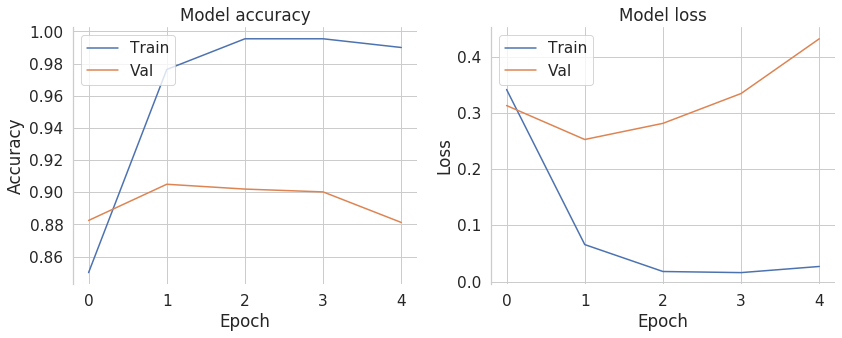

In [25]:
fig = plot_training_curves(history)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/cnn_training.png', dpi=200)

In [27]:
from sklearn import metrics

model.load_weights('/tmp/cnn_weights.hdf5')
probas = model.predict(X_val)
y_pred = (probas > 0.5).astype(np.int)

print("Val Accuracy: {:.2f}".format(metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(metrics.f1_score(y_val, y_pred)))

Test Accuracy: 0.91
Test F1-Score: 0.90


This network also overfits quickly, but it is the best one yet, with almost 91% accuracy on the validation set after the second epoch !

We should test it.

## Testing best CNN model

In [29]:
probas = model.predict(X_test)
y_pred = (probas > 0.5).astype(np.int)

In [30]:
print("Test Accuracy: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred, 
    target_names=class_names.values()
)
print(report)

Test Accuracy: 0.91
Test F1-Score: 0.91

              precision    recall  f1-score   support

    Negative       0.92      0.88      0.90      1988
    Positive       0.89      0.93      0.91      2012

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



# fastText

[fastText classifier](https://fasttext.cc/docs/en/supervised-tutorial.html) works by averaging learned word embeddings. This is exactly what we did for our first model !

However, fastText go further by using n-gram word embeddings. Let's see if we can get better results by using bi-grams !

## Adding bigrams

In [31]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.

    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]

    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])

        new_sequences.append(new_list)

    return new_sequences

def augment_dataset(train_reviews, val_reviews, test_reviews, max_features, ngram_range):
    assert(ngram_range > 1)  
    
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in train_reviews:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1    

    # Augmenting x_train and x_test with n-grams features
    train_ngram = add_ngram(train_reviews, token_indice, ngram_range)
    val_ngram = add_ngram(val_reviews, token_indice, ngram_range)
    test_ngram = add_ngram(test_reviews, token_indice, ngram_range)
    
    return train_ngram, val_ngram, test_ngram, max_features  

In [32]:
ngram_range = 2

print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.

train_ngram, val_ngram, test_ngram, max_ngram_features = augment_dataset(
    train_reviews_tokenized, val_reviews_tokenized, test_reviews_tokenized, 
    MAX_NB_WORDS, ngram_range
)

print('From {} to {} features.'.format(
    MAX_NB_WORDS, max_ngram_features
))

Adding 2-gram features
From 20000 to 367960 features.


Average length: 174.3
Max length: 727


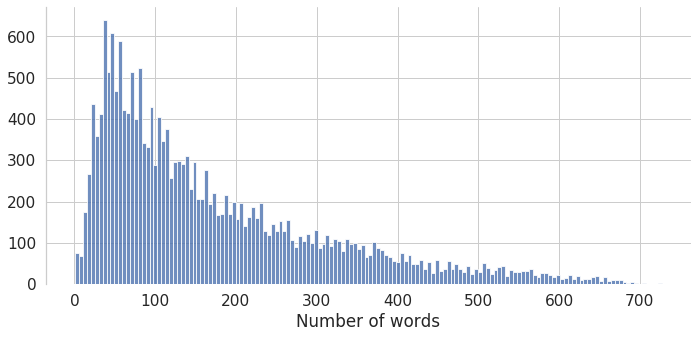

In [33]:
reviews_len = [len(s) for s in train_ngram+val_ngram+test_ngram]
print("Average length: {:.1f}".format(np.mean(reviews_len)))
print("Max length: {}".format(max(reviews_len)))

plt.figure(figsize=(10,5))
ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Number of words')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/word-vectors/number_of_bigrams.png', dpi=200)

## Padding

In [34]:
MAX_LENGTH_SEQ = 700

# truncate long sequences and pad short sequences with 0s
X_train = tf.keras.preprocessing.sequence.pad_sequences(
    train_ngram, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_val = tf.keras.preprocessing.sequence.pad_sequences(
    val_ngram, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_ngram, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

print('Shape of X_train tensor:', X_train.shape)
print('Shape of X_val tensor:', X_val.shape)
print('Shape of X_test tensor:', X_test.shape)

Shape of X_train tensor: (12000, 700)
Shape of X_val tensor: (4000, 700)
Shape of X_test tensor: (4000, 700)


In [35]:
from tensorflow import keras
from tensorflow.keras import layers

embedding_dim = 128
max_features = max_ngram_features

model = keras.models.Sequential(name="fastText")
model.add(layers.Embedding(max_features, embedding_dim,
                           input_shape=[None]),)
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [36]:
model.summary()

Model: "fastText"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         47098880  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 47,099,009
Trainable params: 47,099,009
Non-trainable params: 0
_________________________________________________________________


## Training

In [37]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/fasttext_weights.hdf5',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20, batch_size=32, 
    callbacks=[checkpointer], verbose=1)

Train on 12000 samples, validate on 4000 samples
Epoch 1/20
11968/12000 [============================>.] - ETA: 0s - loss: 0.6789 - accuracy: 0.6166
Epoch 00001: val_loss improved from inf to 0.65291, saving model to /tmp/fasttext_weights.hdf5
12000/12000 [==============================] - 123s 10ms/sample - loss: 0.6789 - accuracy: 0.6167 - val_loss: 0.6529 - val_accuracy: 0.7308
Epoch 2/20
11968/12000 [============================>.] - ETA: 0s - loss: 0.5707 - accuracy: 0.8227
Epoch 00002: val_loss improved from 0.65291 to 0.51335, saving model to /tmp/fasttext_weights.hdf5
12000/12000 [==============================] - 124s 10ms/sample - loss: 0.5705 - accuracy: 0.8230 - val_loss: 0.5133 - val_accuracy: 0.8600
Epoch 3/20
11968/12000 [============================>.] - ETA: 0s - loss: 0.4056 - accuracy: 0.9072
Epoch 00003: val_loss improved from 0.51335 to 0.40840, saving model to /tmp/fasttext_weights.hdf5
12000/12000 [==============================] - 135s 11ms/sample - loss: 0.4053

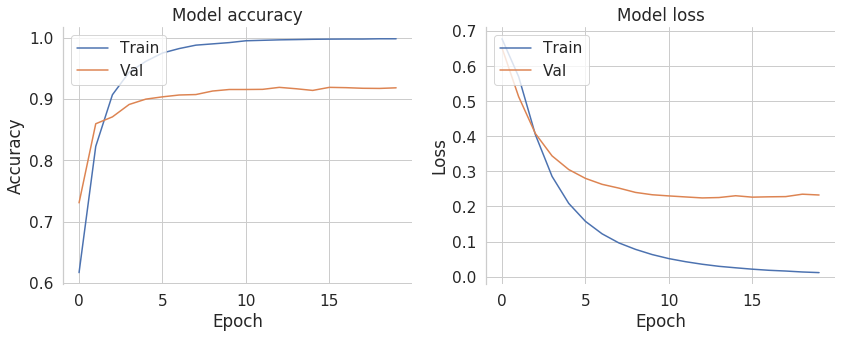

In [38]:
fig = plot_training_curves(history)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/fasttext_training.png', dpi=200)

In [39]:
model.load_weights('/tmp/fasttext_weights.hdf5')
probas = model.predict(X_val)
y_pred = (probas > 0.5).astype(np.int)

print("Val Accuracy: {:.2f}".format(metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(metrics.f1_score(y_val, y_pred)))

Val Accuracy: 0.92
Val F1-Score: 0.92


## Testing best fastText model

In [40]:
probas = model.predict(X_test)
y_pred = (probas > 0.5).astype(np.int)

In [41]:
print("Test Accuracy: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred, 
    target_names=class_names.values()
)
print(report)

Test Accuracy: 0.91
Test F1-Score: 0.91

              precision    recall  f1-score   support

    Negative       0.90      0.91      0.91      1988
    Positive       0.91      0.91      0.91      2012

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



In [138]:
# TODO: test RNN & CNN on smaller part of the dataset, (accuracy as a function of dataset size) as RNN should decrease in accuracy with a smaller dataset